## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-17 11:25:04.885231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:28.1100000Z', 'time_close': '2023-09-17T15:25:30.0990000Z', 'price_open': 26571, 'price_high': 26618, 'price_low': 26432, 'price_close': 26561, 'volume_traded': 310.51250597, 'trades_count': 4333}, {'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:00:06.6310000Z', 'time_close': '2023-09-16T23:59:36.1270000Z', 'price_open': 26609, 'price_high': 26767, 'price_low': 26459, 'price_close': 26571, 'volume_traded': 602.34030269, 'trades_count': 7658}, {'time_period_start': '2023-09-15T00:00:00.0000000Z', 'time_period_end': '2023-09-16T00:00:00.0000000Z', 'time_open': '2023-09-15T00:00:32.9490000Z', 'time_close': '2023-09-15T23:59:45.8940000Z', 'price_open': 26529, 'price_high': 26878, 'price_low': 26228, 'price_close': 26607, 'volume_traded': 1379.10563562, 'trades_count': 119

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:28.1100000Z,2023-09-17T15:25:30.0990000Z,26571.0,26618.0,26432.0,26561.0,310.512506,4333
1,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:06.6310000Z,2023-09-16T23:59:36.1270000Z,26609.0,26767.0,26459.0,26571.0,602.340303,7658
2,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:32.9490000Z,2023-09-15T23:59:45.8940000Z,26529.0,26878.0,26228.0,26607.0,1379.105636,11902
3,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:15.5360000Z,2023-09-14T23:59:56.7440000Z,26229.0,26849.0,26143.0,26529.0,2067.195177,14687
4,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:00:26.7790000Z,2023-09-13T23:59:42.8740000Z,25842.0,26395.0,25762.0,26226.0,1562.755225,12274


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


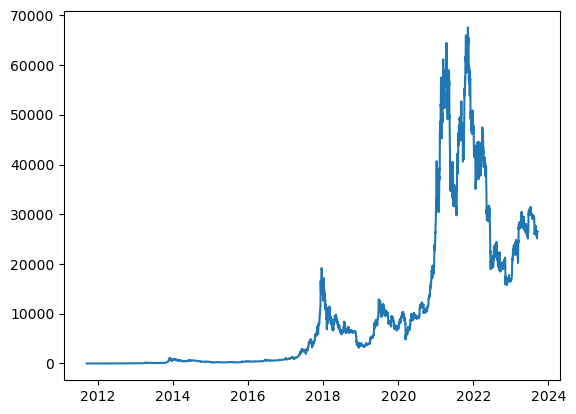

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4228, 7), (4228,), (4228,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3382, 7), (3382,), (423, 7), (423,), (423, 7), (423,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-17 11:26:59.101325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 4s 11ms/step - loss: 9.2253 - mean_absolute_error: 1.9594 - val_loss: 0.2675 - val_mean_absolute_error: 0.4926
Epoch 2/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0130 - mean_absolute_error: 0.0720 - val_loss: 0.0553 - val_mean_absolute_error: 0.2186
Epoch 3/100
106/106 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0539 - val_loss: 0.0118 - val_mean_absolute_error: 0.0899
Epoch 4/100
106/106 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0504 - val_loss: 0.0048 - val_mean_absolute_error: 0.0548
Epoch 5/100
106/106 [==============================] - 1s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0481 - val_loss: 0.0052 - val_mean_absolute_error: 0.0582
Epoch 6/100
106/106 [==============================] - 1s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0480 - val_loss: 0.0038 - val_mean_absolute_error: 0.0486
Epoch 7/

106/106 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0409 - val_loss: 0.0022 - val_mean_absolute_error: 0.0378
Epoch 51/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0390 - val_loss: 0.0037 - val_mean_absolute_error: 0.0494
Epoch 52/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0371 - val_loss: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 53/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0435 - val_loss: 0.0024 - val_mean_absolute_error: 0.0396
Epoch 54/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0120 - val_mean_absolute_error: 0.1017
Epoch 55/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0401 - val_loss: 0.0017 - val_mean_absolute_error: 0.0304
Epoch 56/100
106/

106/106 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0421 - val_loss: 0.0036 - val_mean_absolute_error: 0.0500
Epoch 100/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0390 - val_loss: 0.0021 - val_mean_absolute_error: 0.0349


106/106 [==============================] - 1s 3ms/step


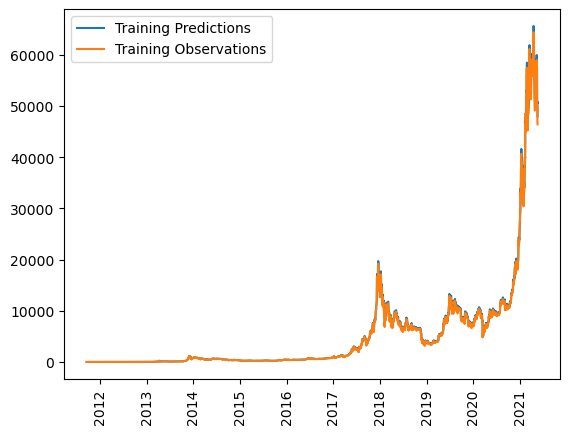

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00206351769156754
Val MAE: 0.03493107855319977


14/14 [==============================] - 0s 3ms/step


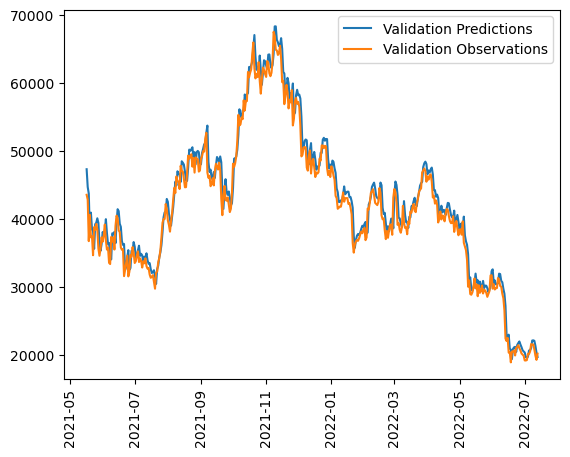

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.001225140644237399
Test MAE: 0.028586065396666527


14/14 [==============================] - 0s 3ms/step


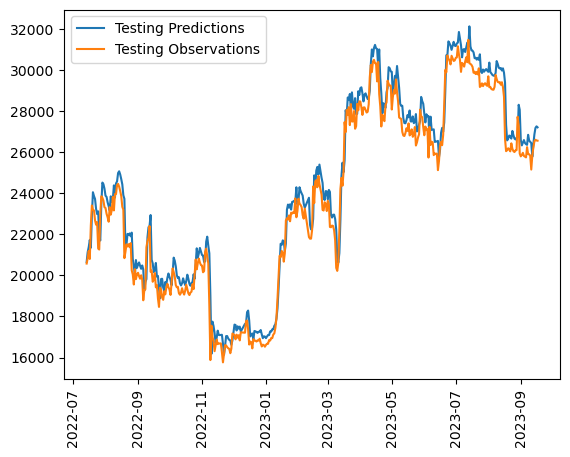

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [17]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9674967418989806


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [18]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [19]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1648,),
 (1648, 7),
 (1648,),
 (254,),
 (254, 7),
 (254,),
 (212,),
 (212, 7),
 (212,))

In [60]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
106/106 [==============================] - 4s 15ms/step - loss: 36.5182 - mean_absolute_error: 5.5647 - val_loss: 64.3774 - val_mean_absolute_error: 8.0188
Epoch 2/300
106/106 [==============================] - 1s 7ms/step - loss: 11.8796 - mean_absolute_error: 2.8136 - val_loss: 17.7185 - val_mean_absolute_error: 4.1997
Epoch 3/300
106/106 [==============================] - 1s 6ms/step - loss: 2.3656 - mean_absolute_error: 1.3350 - val_loss: 8.0037 - val_mean_absolute_error: 2.8159
Epoch 4/300
106/106 [==============================] - 1s 6ms/step - loss: 0.9430 - mean_absolute_error: 0.8192 - val_loss: 3.8667 - val_mean_absolute_error: 1.9519
Epoch 5/300
106/106 [==============================] - 1s 9ms/step - loss: 0.3186 - mean_absolute_error: 0.4359 - val_loss: 1.8128 - val_mean_absolute_error: 1.3288
Epoch 6/300
106/106 [==============================] - 1s 7ms/step - loss: 0.1202 - mean_absolute_error: 0.2471 - val_loss: 0.9040 - val_mean_absolute_error: 0.9302
Epoch

106/106 [==============================] - 1s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0463 - val_loss: 0.0037 - val_mean_absolute_error: 0.0467
Epoch 51/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0444 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 52/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0444 - val_loss: 0.0035 - val_mean_absolute_error: 0.0456
Epoch 53/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0440 - val_loss: 0.0040 - val_mean_absolute_error: 0.0482
Epoch 54/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0046 - mean_absolute_error: 0.0445 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 55/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0440 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 56/300
106/

106/106 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0378 - val_loss: 0.0027 - val_mean_absolute_error: 0.0405
Epoch 100/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0402 - val_loss: 0.0032 - val_mean_absolute_error: 0.0430
Epoch 101/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0384 - val_loss: 0.0051 - val_mean_absolute_error: 0.0566
Epoch 102/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0385 - val_loss: 0.0029 - val_mean_absolute_error: 0.0413
Epoch 103/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0379 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436
Epoch 104/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0385 - val_loss: 0.0028 - val_mean_absolute_error: 0.0409
Epoch 105/30

106/106 [==============================] - 1s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0354 - val_loss: 0.0045 - val_mean_absolute_error: 0.0539
Epoch 149/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0364 - val_loss: 0.0020 - val_mean_absolute_error: 0.0345
Epoch 150/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0363 - val_loss: 0.0025 - val_mean_absolute_error: 0.0397
Epoch 151/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0345 - val_loss: 0.0022 - val_mean_absolute_error: 0.0355
Epoch 152/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0355 - val_loss: 0.0021 - val_mean_absolute_error: 0.0345
Epoch 153/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0341 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376
Epoch 154/30

106/106 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0333 - val_loss: 0.0031 - val_mean_absolute_error: 0.0438
Epoch 198/300
106/106 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0020 - val_mean_absolute_error: 0.0338
Epoch 199/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0337 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 200/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0336 - val_loss: 0.0023 - val_mean_absolute_error: 0.0390
Epoch 201/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0319 - val_loss: 0.0020 - val_mean_absolute_error: 0.0335
Epoch 202/300
106/106 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_absolute_error: 0.0320 - val_loss: 0.0018 - val_mean_absolute_error: 0.0336
Epoch 203

106/106 [==============================] - 1s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0343 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318
Epoch 247/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0337 - val_loss: 0.0027 - val_mean_absolute_error: 0.0406
Epoch 248/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0320 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332
Epoch 249/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0338 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303
Epoch 250/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0321 - val_loss: 0.0016 - val_mean_absolute_error: 0.0299
Epoch 251/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0019 - val_mean_absolute_error: 0.0349
Epoch 252/30

106/106 [==============================] - 1s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0313 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293
Epoch 296/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0321 - val_loss: 0.0018 - val_mean_absolute_error: 0.0334
Epoch 297/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0330 - val_loss: 0.0016 - val_mean_absolute_error: 0.0294
Epoch 298/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0335 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 299/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0348 - val_loss: 0.0029 - val_mean_absolute_error: 0.0435
Epoch 300/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0322 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429


52/52 [==============================] - 1s 4ms/step


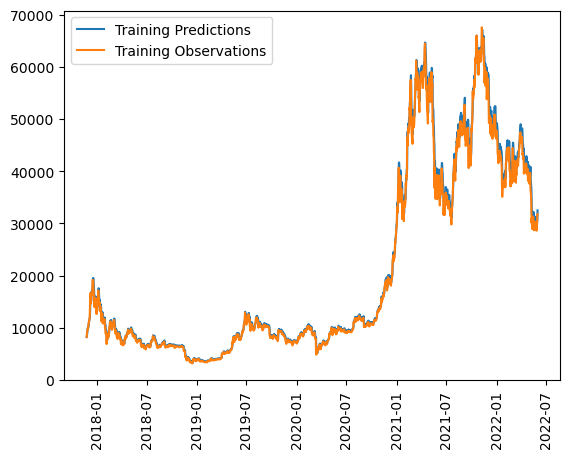

In [61]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [62]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00229137041606009
Val MAE: 0.03881625458598137


8/8 [==============================] - 0s 3ms/step


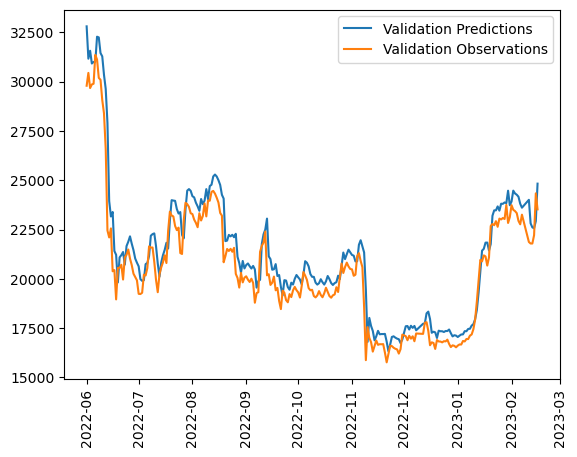

In [63]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [64]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0017646931810304523
Test MAE: 0.038004372268915176


In [65]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 5ms/step
R2 Score:  0.7657211595128824


7/7 [==============================] - 0s 4ms/step


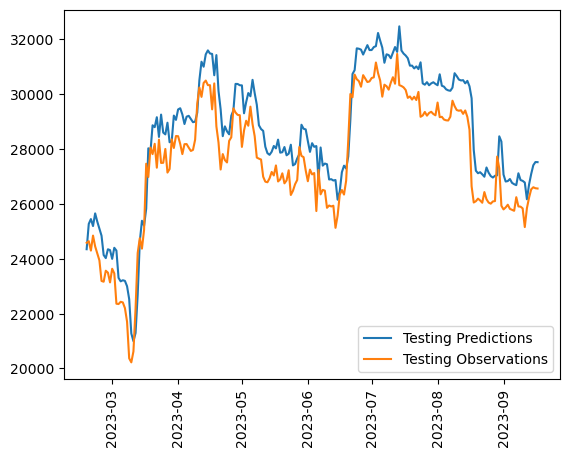

In [66]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [27]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 3s 17ms/step - loss: 45.4096 - mean_absolute_error: 6.1009 - val_loss: 0.2559 - val_mean_absolute_error: 0.4852
Epoch 2/300
52/52 [==============================] - 0s 7ms/step - loss: 0.8830 - mean_absolute_error: 0.8075 - val_loss: 0.1116 - val_mean_absolute_error: 0.3027
Epoch 3/300
52/52 [==============================] - 0s 7ms/step - loss: 0.7179 - mean_absolute_error: 0.7441 - val_loss: 0.1335 - val_mean_absolute_error: 0.3373
Epoch 4/300
52/52 [==============================] - 0s 7ms/step - loss: 0.7063 - mean_absolute_error: 0.7356 - val_loss: 0.1966 - val_mean_absolute_error: 0.4211
Epoch 5/300
52/52 [==============================] - 0s 8ms/step - loss: 0.6874 - mean_absolute_error: 0.7268 - val_loss: 0.1590 - val_mean_absolute_error: 0.3746
Epoch 6/300
52/52 [==============================] - 0s 7ms/step - loss: 0.6574 - mean_absolute_error: 0.7089 - val_loss: 0.1460 - val_mean_absolute_error: 0.3587
Epoch 7/300
52/52 [=

Epoch 51/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0499 - val_loss: 0.0023 - val_mean_absolute_error: 0.0310
Epoch 52/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0472 - val_loss: 0.0105 - val_mean_absolute_error: 0.0918
Epoch 53/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0024 - val_mean_absolute_error: 0.0330
Epoch 54/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 0.0079 - val_mean_absolute_error: 0.0771
Epoch 55/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 56/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0458 - val_loss: 0.0031 - val_mean_absolute_error: 0.0448
Epoch 57/300
52/

Epoch 101/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0070 - val_mean_absolute_error: 0.0775
Epoch 102/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0052 - val_mean_absolute_error: 0.0610
Epoch 103/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0402 - val_loss: 0.0019 - val_mean_absolute_error: 0.0324
Epoch 104/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0402 - val_loss: 0.0051 - val_mean_absolute_error: 0.0609
Epoch 105/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0030 - val_mean_absolute_error: 0.0465
Epoch 106/300
52/52 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0417 - val_loss: 0.0098 - val_mean_absolute_error: 0.0937
Epoch 107/

52/52 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0385 - val_loss: 0.0035 - val_mean_absolute_error: 0.0493
Epoch 151/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0018 - val_mean_absolute_error: 0.0332
Epoch 152/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0049 - val_mean_absolute_error: 0.0642
Epoch 153/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0398 - val_loss: 0.0024 - val_mean_absolute_error: 0.0376
Epoch 154/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0393 - val_loss: 0.0022 - val_mean_absolute_error: 0.0383
Epoch 155/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0422 - val_loss: 0.0054 - val_mean_absolute_error: 0.0656
Epoch 156/300
52/52 [==

Epoch 200/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 0.0033 - val_mean_absolute_error: 0.0492
Epoch 201/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0358 - val_loss: 0.0018 - val_mean_absolute_error: 0.0339
Epoch 202/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0035 - val_mean_absolute_error: 0.0513
Epoch 203/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0432 - val_loss: 0.0029 - val_mean_absolute_error: 0.0449
Epoch 204/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0410 - val_loss: 0.0015 - val_mean_absolute_error: 0.0273
Epoch 205/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 0.0025 - val_mean_absolute_error: 0.0413
Epoch 206/

Epoch 250/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0329 - val_loss: 0.0012 - val_mean_absolute_error: 0.0228
Epoch 251/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0388 - val_loss: 0.0012 - val_mean_absolute_error: 0.0235
Epoch 252/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0366 - val_loss: 0.0016 - val_mean_absolute_error: 0.0300
Epoch 253/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0422 - val_loss: 0.0012 - val_mean_absolute_error: 0.0237
Epoch 254/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0039 - val_mean_absolute_error: 0.0546
Epoch 255/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - val_loss: 0.0016 - val_mean_absolute_error: 0.0295
Epoch 256/

Epoch 300/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256


52/52 [==============================] - 1s 3ms/step


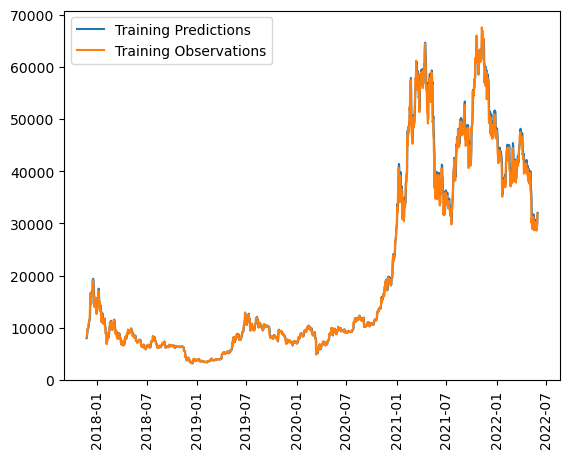

In [29]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [30]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0013112887972965837
Val MAE: 0.02558920346200466


8/8 [==============================] - 0s 3ms/step


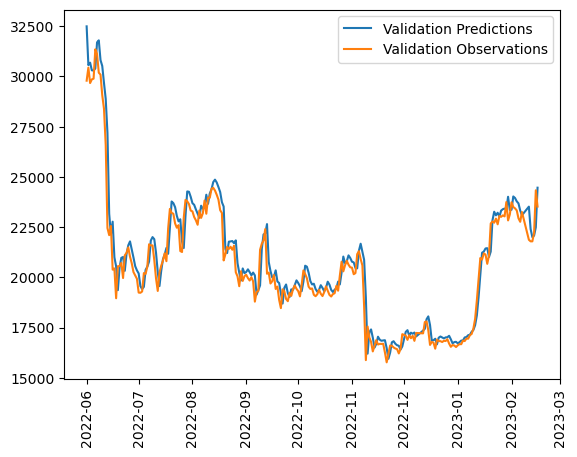

In [31]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [32]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0007563994149677455
Test MAE: 0.022100651636719704


7/7 [==============================] - 0s 3ms/step


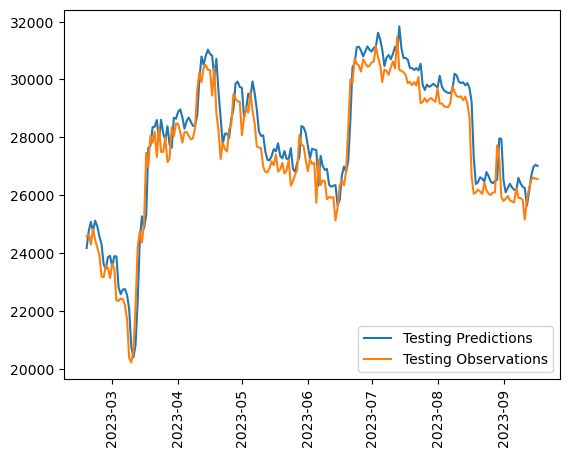

In [33]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [34]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8995809760577812


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [69]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, 0, current_pred)
    
    #resize batch 
    current_batch = updated_batch[0:7]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 28ms/step
[10.204018, 10.205519, 10.202387, 10.19101, 10.169529, 10.148213, 10.180995]
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24


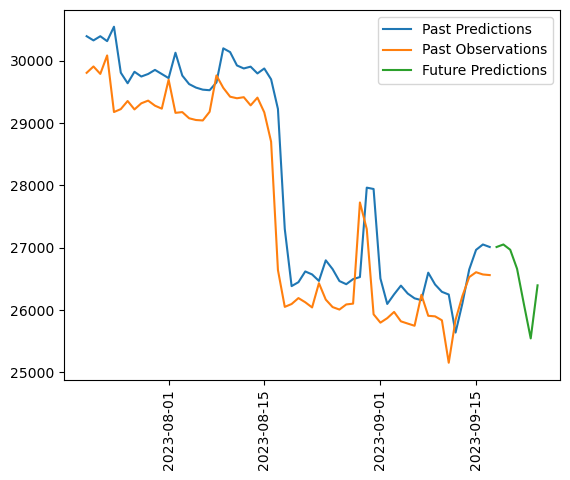

In [71]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [72]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [73]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [74]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [75]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-19,26842.0,26994.107422,27288.664062,26806.753906
2023-06-20,28315.0,27447.640625,27729.873047,27191.017578
2023-06-21,30009.0,28940.958984,29082.703125,28624.142578
2023-06-22,29889.0,30722.609375,30737.818359,30422.390625
2023-06-23,30716.0,30711.681641,30879.763672,30562.146484
...,...,...,...,...
2023-09-13,26226.0,26390.074219,26702.958984,26106.882812
2023-09-14,26529.0,26870.464844,27088.648438,26651.437500
2023-09-15,26607.0,27180.591797,27409.898438,26965.804688


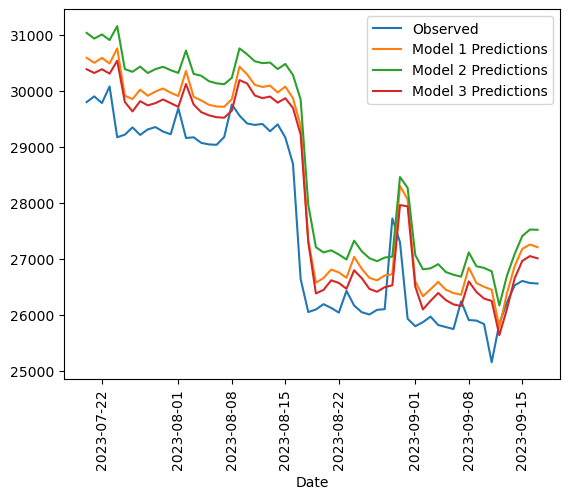

In [76]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [77]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [78]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [79]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9674967418989806
Model 2 R2 Score:  0.7657211595128824
Model 3 R2 Score:  0.8995809760577812
